BallTree implementation is inspired from https://youtu.be/E1_WCdUAtyE

Current implementation does:
1. BallTree construction (fit)
2. searching for one closest neighbor (query)
3. final tree visualization (non-interractive)

Further improvements:
1. introduce leaf size (currently it's one)?
2. allow to pass to query several points at a time (X instead of x)?
3. implement query radius method?
4. implement tree descriptive statistics (depth, num nodes, ratio of visited nodes, etc.)
5. optimize code (e.g. omit coppying data)
6. create interractive visualization
7. prettify & document code ;)

In [1092]:
import os
import re
import operator
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.neighbors import BallTree
from scipy.spatial import distance_matrix
import glob
from PIL import Image
from optimizer import Optimizer
from IPython import display
import heapq

In [2036]:
def pick_i(X):
    return np.random.randint(0, len(X))
       
        
def get_farthest_i(X, i):
    dists = distance_matrix(X[[i]], X)[0]
    i_max = np.argmax(dists)
    return i_max
    

def project_onto_line(X, w):
    w = np.expand_dims(w, axis=-1)
    proj = X @ w
    return proj[:, 0]
    

def dist2(x1, x2):
    return np.sum((x1 - x2)**2)


def dist_to_sphere(x, c, r):
    return np.sqrt(np.sum((c - x)**2)) - r


def approx_pca(X):
    # pick random point from the dataset
    i0 = pick_i(X)
    x0 = X[i0]

    # pick farthers point from the previous one
    i1 = get_farthest_i(X, i0)
    x1 = X[i1]

    # again, pick farthers point from the previous one
    i2 = get_farthest_i(X, i1)
    x2 = X[i2]
    
    # create vector describing that axis
    w = x1 - x2
    
    return w


def display_animation(fig, folder='animate'):
    plt.close(fig)
            
    frames = []
    images = glob.glob(f"{folder}/*.png")

    # extract image file names as numbers
    order = list(map(int, [re.search('\d+', s)[0] for s in images]))
    # sort images by their names as numbers
    pairs = sorted(zip(images, order), key=operator.itemgetter(1))

    # create frames
    frames = [Image.open(file) for file, _ in pairs]

    # Save into a GIF file that loops forever
    frames[0].save('BallTreeConstruction.gif', 
                   format='GIF', loop=0,
                   append_images=frames[1:],
                   save_all=True, duration=1500)
    
    # display gif
    with open('BallTreeConstruction.gif','rb') as file:
        display.display(display.Image(file.read()))

    
class BallTreeNode:
    def __init__(self, c, r, idx):
        self.c = c
        self.r = r
        self.idx = idx
        self._left = None
        self._right = None
        self.visited = 0  
        self.level = None
        
    @property
    def left(self):
        return self._left  
    
    @left.setter
    def left(self, ball_tree_node):
        if not isinstance(ball_tree_node, BallTreeNode):
            raise TypeError('invalid children data type')
        self._left = ball_tree_node
    
    @property
    def right(self):
        return self._right
      
    @right.setter
    def right(self, ball_tree_node):
        if not isinstance(ball_tree_node, BallTreeNode):
            raise TypeError('invalid children data type')
        self._right = ball_tree_node
    
    @property
    def is_leaf(self):
        return self.left is None and self.right is None
    
    def __str__(self):
        if self.is_leaf:
            return f'Leaf node at {self.c}'
        else:
            return f'Inner node with center at {self.c} and radius {self.r}'
    
    def __repr__(self):
        return f'BallTreeNode(c={self.c}, r={self.r})'


class BallTreeOptimizer(Optimizer):
    def __init__(self, X: np.ndarray, leaf_size=1):
        self.X = np.copy(X)
        self.leaf_size = leaf_size
        self.depth = 0
        self.num_nodes = 0
        self.num_leaves = 0
        self.num_visited = 0
        self._num_calls = 0
        
        idx_all = np.arange(len(X))
        self.root = self._build_ball_tree(idx_all)
        
    def __repr__(self):
        return f'BallTreeOptimizer()'

    @property
    def num_internal(self):
        return self.num_nodes - self.num_leaves        
        
    def _build_ball_tree(self, idx, level=0):
        # update tree stats
        self.depth = max(self.depth, level)
        self.num_nodes += 1
        
        # calculate center and radius for the current ball;
        # center is a mean of all the data points;
        # radius determines by the farthers point from the center
        c = np.mean(X[idx], axis=0)
        r = np.max(distance_matrix(X[idx], [c]))
        
        # create corresponding node
        node = BallTreeNode(c=c, r=r, idx=idx)
        node.level = level
        
        # if more than leaf_size nodes remains proceed splitting
        if len(idx) > self.leaf_size:
            # find the axis of the greatest spread (approx)
            w = approx_pca(X[idx]) 

            # we project all the points onto the line and obtain a vector of numbers (1-D)
            proj = project_onto_line(X[idx], w)

            # get indices of projection order to mask left and righ part
            order = np.argsort(proj)

            # split midpoint
            mi = len(proj) // 2

            # split to the left and right sub-parts
            idx_left = idx[order[:mi]]
            idx_right = idx[order[mi:]]    

            # construct node's children by recursive calls
            node.left = self._build_ball_tree(idx_left, level=level+1)
            node.right = self._build_ball_tree(idx_right, level=level+1)
        else:
            self.num_leaves += 1
                    
        return node
 
    def query(self, x, k=1):
        self._closest_idxs = np.repeat(-1, k)
        self._closest_dists = np.repeat(np.inf, k)
        self._num_calls += 1
        self._num_visited = 0
        
        self._query(self.root, x, k)
        return self._closest_dists, self._closest_idxs
    
    def _query(self, node, x, k):
        # mark node as visited with call number;
        # in that way we can later recognize all the visited 
        # nodes in the previous call
        node.visited = self._num_calls
        self.num_visited += 1

        # if node is leaf we try to update current closest neighbor
        if node.is_leaf:
            dists = distance_matrix(self.X[node.idx], [x])[:,0]

            new_closest_idxs = np.argsort(dists)[:k]
            new_closest_dists = dists[new_closest_idxs]
            new_closest_idxs = node.idx[new_closest_idxs]
            
            self._closest_dists = np.hstack([self._closest_dists, new_closest_dists])
            self._closest_idxs = np.hstack([self._closest_idxs, new_closest_idxs])
            
            order = np.argsort(self._closest_dists)
            
            self._closest_dists = self._closest_dists[order[:k]]
            self._closest_idxs = self._closest_idxs[order[:k]]
            
            # for new_closest_idx, new_closest_dist in zip(new_closest_idxs, new_closest_dists):
            #     max_closest_dist_idx = np.argmin(self._closest_dists)
            #     if new_closest_dist < self._closest_dists[max_closest_dist_idx]:
            #         self._closest_idxs[max_closest_dist_idx] = node.idx[new_closest_idx]
            #         self._closest_dists[max_closest_dist_idx] = new_closest_dist
        else:  # otherwise visit children
            nodes_to_visit = []
            
            # create a queue of nodes to visit + precompute metrics
            if node.left is not None:
                center_to_left2 = dist2(x, node.left.c)
                sphere_to_left = dist_to_sphere(x, node.left.c, node.left.r)
                nodes_to_visit.append([center_to_left2, sphere_to_left, node.left])

            if node.right is not None:
                center_to_right2 = dist2(x, node.right.c)
                sphere_to_right = dist_to_sphere(x, node.right.c, node.right.r)
                nodes_to_visit.append([center_to_right2, sphere_to_right, node.right])
            
            # order queue by distance from the target to ball center;
            # i.e. visit closer ball at first
            nodes_to_visit.sort(key=operator.itemgetter(0))

            # iterate over queue and visit ball if it intersects 
            # with current smallest neighbor distance
            for _, sphere_to_node, node in nodes_to_visit:
                if sphere_to_node < np.max(self._closest_dists):
                    self._query(node, x, k)
                                    
    def plot(self, animate=False, show_visted=False, show_level=None, fig_ax=None):   
        # clean animation snapshots directory
        if animate:
            images = glob.glob("animate/*.png")
            for file in images:
                os.remove(file)
        
        # create figure
        if fig_ax is None:
            fig, ax = plt.subplots(figsize=(10,10))
        else:
            fig, ax = fig_ax
            
        ax.axis('equal')
        
        # draw data points
        ax.scatter(self.X[:,0], self.X[:,1], 
                   c='r', s=100, linewidth=2, 
                   edgecolor='white', zorder=2*(self.depth+1))
        
        # set up axes
        offset_ratio = 0.15
        xoffset = (self.X[:, 0].max() - self.X[:, 0].min()) * offset_ratio
        yoffset = (self.X[:, 1].max() - self.X[:, 1].min()) * offset_ratio
        ax.set_xlim(self.root.c[0]-self.root.r-xoffset, self.root.c[0]+self.root.r+xoffset)
        ax.set_ylim(self.root.c[1]-self.root.r-yoffset, self.root.c[1]+self.root.r+yoffset)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # prepare variables
        cmap = plt.get_cmap('gray_r')
        level_colors = np.linspace(0.1, 0.6, self.depth+1)[::-1]
        prev_node = None
        queue = [self.root]
        
        # perform BFS throughout nodes to create balls
        for node in queue:
            if node is not None:  
                if show_level is None or node.level == show_level:
                    # we will separately create ball filling and boundary
                    fill_color = cmap(level_colors[node.level])
                    edge_color = 'blue' if show_visted and node.visited == self._num_calls else 'white'
                    circle_inner = plt.Circle(node.c, node.r, facecolor=fill_color, zorder=2*node.level)
                    circle_boundary = plt.Circle(node.c, node.r,  edgecolor=edge_color, linewidth=2, 
                                                 fill=False, zorder=2*node.level+1)
                    
                    # if we enter new level, save figure before drawing new circle
                    if animate and (prev_node is None or node.level != prev_node.level):
                        fig.tight_layout()
                        fig.savefig(f'animate/{node.level}.png')
                        prev_node = node
                        
                    # draw circles
                    ax.add_patch(circle_inner) 
                    ax.add_patch(circle_boundary) 
                            
                # update queue
                queue.append(node.left)
                queue.append(node.right)
                
        # disaply animation
        if animate:
            fig.savefig(f'animate/{self.depth+1}.png')
            display_animation(fig)
                
    def get_k_nearest(self, X: np.ndarray) -> np.ndarray:
        pass
    
    def traverse(self):
        def _traverse(node):
            if node is not None:
                if node.is_leaf:
                    x = len(node.idx)
                _traverse(node.left)
                _traverse(node.right)
        _traverse(self.root)

In [2037]:
np.random.seed(42)

In [2038]:
def test_ball_tree():
    for n in tqdm([10, 100, 1000]):
        for d in tqdm([1, 2, 3, 4, 10, 20, 30]): 
            X = np.random.randn(n, d)
            x = np.random.randn(d)
            
            sk_bt = BallTree(X)
            my_bt = BallTreeOptimizer(X)
            
            my_dist, my_point = my_bt.query(x)
            
            sk_dist, sk_idx = sk_bt.query([x])
            sk_point = X[sk_idx][0, 0]
            
            assert np.allclose(my_point, sk_point), (my_point, sk_point)

In [2039]:
# test_ball_tree()

In [2040]:
from sklearn.datasets import make_circles, make_s_curve, make_moons

In [2041]:
d = 2
k = 3
leaf_size = 7
# X = np.random.randn(100, d)
# X, _ = make_moons(10, noise=0.1)
# space = np.linspace(0, 2*np.pi, 100)[:,np.newaxis]
# X = np.hstack([space, np.sin(space)]) + 0.2 * np.random.randn(100)[:,np.newaxis]
# x = X[np.random.randint(0, len(X))] + np.random.randn()

sk_bt = BallTree(X, leaf_size=leaf_size)
my_bt = BallTreeOptimizer(X, leaf_size=leaf_size)

In [2042]:
my_dist, my_idx = my_bt.query(x, k=k)
my_point = X[my_idx]
my_dist, my_point

(array([0.85257688, 0.93880958, 1.04956374]),
 array([[ 4.33115139, -0.20707523],
        [ 4.7128391 , -0.43541139],
        [ 4.39285284, -0.46476617]]))

In [2043]:
sk_dist, sk_idx = sk_bt.query([x], k=k)
sk_point = X[sk_idx][0]
sk_dist = sk_dist[0]
sk_dist, sk_point

(array([0.85257688, 0.93880958, 1.04956374]),
 array([[ 4.33115139, -0.20707523],
        [ 4.7128391 , -0.43541139],
        [ 4.39285284, -0.46476617]]))

In [2044]:
np.allclose(sk_point, my_point)

True

In [2045]:
my_bt.depth, my_bt.num_nodes, my_bt.num_leaves

(4, 31, 16)

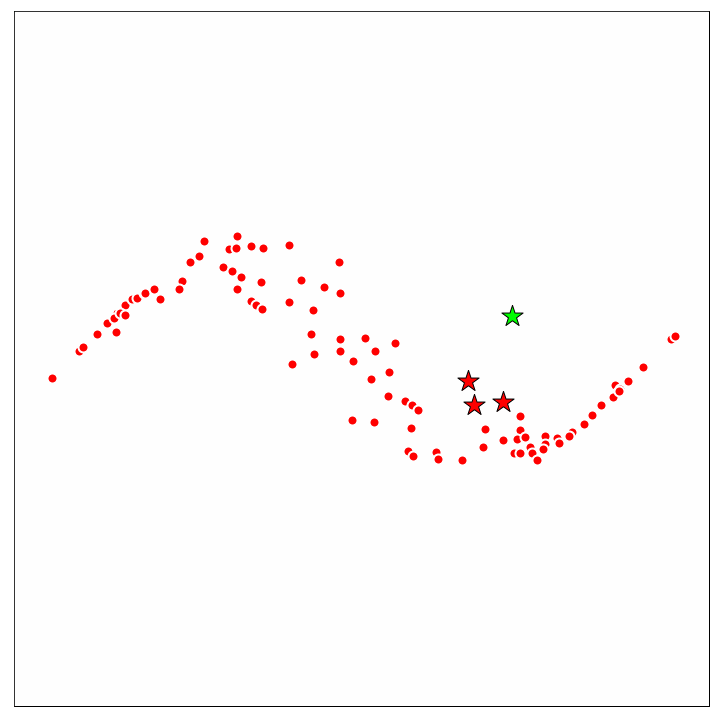

In [2046]:
# green - visited balls
# number in vall center - order of visit
# yellow triangle - target point
# red square - nearest neighbor
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter([x[0]], [x[1]], marker='*', s=500, color='lime', zorder=1000, edgecolor='black')
ax.scatter(my_point[:,0], my_point[:,1], marker='*', s=500, color='red', zorder=1001, edgecolor='black')
my_bt.plot(animate=True, fig_ax=(fig, ax))

In [1932]:
"""
NumPy based implemenation of min-heap data structure.
"""

import numpy as np


class Heap(object):

    def __init__(self, length=2):
        self.heap = np.zeros(length)
        self.heap.fill(np.nan)
        self.size = 0

    def get_parent_idx(self, child_idx):
        if child_idx % 2 == 0:
            parent_idx = int(child_idx / 2 - 1)
        else:
            parent_idx = int(np.floor(child_idx / 2))
        return parent_idx

    def get_parent(self, child_idx):
        parent_idx = self.get_parent_idx(child_idx)
        return self.heap[parent_idx]

    def insert(self, key):
        print('Inserting key ' + str(key))
        if type(key) == list or type(key) == np.ndarray:
            for i in range(len(key) - 1):
                self.insert(key[i])
            key = key[-1]

        if self.heap.shape[0] == self.size + 1:  # Check if heap is at max capacity
            # Resize heap to double the current capacity
            self.heap = np.resize(self.heap, self.heap.shape[0] * 2)
        elif self.heap.shape[0] > self.size * 4:
            self.heap = np.resize(self.heap, int(self.heap.shape[0] / 2) + 1)

        self.heap[self.size] = key
        key_idx = self.size
        parent_idx = self.get_parent_idx(key_idx)

        # Bubble up until heap property is restored
        while self.heap[key_idx] < self.heap[parent_idx]:
            temp = self.heap[parent_idx]
            self.heap[parent_idx] = self.heap[key_idx]
            self.heap[key_idx] = temp
            key_idx = parent_idx
            parent_idx = self.get_parent_idx(key_idx)

        self.size += 1

    def get_left_child_idx(self, parent_idx):
        return 2 * parent_idx + 1

    def get_right_child_idx(self, parent_idx):
        return 2 * parent_idx + 2

    def get_left_child(self, parent_idx):
        left_child = self.heap[self.get_left_child_idx(parent_idx)]
        return left_child

    def get_right_child(self, parent_idx):
        right_child = self.heap[self.get_right_child_idx(parent_idx)]
        return right_child

    def get_children_idx(self, parent_idx):
        return 2 * parent_idx + 1, 2 * parent_idx + 2

    def get_children(self, parent_idx):
        child_1_idx, child_2_idx = self.get_parent_idx(parent_idx)
        return self.heap[child_1_idx], self.heap[child_2_idx]

    def extract_min(self):
        root = self.heap[0]
        self.size -= 1
        self.heap[0] = self.heap[self.size]
        self.heap[self.size] = np.nan

        key_idx = 0
        c1_idx, c2_idx = self.get_children_idx(key_idx)

        # Bubble down root until heap property restored
        while self.heap[key_idx] > self.heap[c1_idx] or self.heap[key_idx] > self.heap[c2_idx]:
            if self.heap[c1_idx] < self.heap[c2_idx]:
                smaller_child_idx = c1_idx
            else:
                smaller_child_idx = c2_idx
            temp = self.heap[smaller_child_idx]
            self.heap[smaller_child_idx] = self.heap[key_idx]
            self.heap[key_idx] = temp

            key_idx = smaller_child_idx
            c1_idx, c2_idx = self.get_children_idx(key_idx)
            if c1_idx >= self.size or c2_idx >= self.size:
                break

        return root